# Аугментация

In [1]:
import albumentations as alb
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
size_img = (300, 300)
count_aug = 50
count_images = 4

In [3]:
def gen_aug(index, sub_index):
    img = cv2.imread(f'input\img\image{index}.png')
    mask = cv2.imread(f'input\mask\mask{index}.png')
    
    # Создание объекта аугментации
    transform = alb.Compose([
        alb.HorizontalFlip(p=0.5),
        alb.VerticalFlip(p=0.5),
        alb.RandomRotate90(p=0.5),
        alb.Affine(translate_percent={"x": 0.1, "y": 0.1}, rotate=(-45, 45), scale=(0.8, 1.2), p=1.0),
        alb.RandomScale(scale_limit=0.1, p=0.5), 
        alb.RandomCrop(height=size_img[0], width=size_img[1], p=0.5), 
        alb.RandomBrightnessContrast(p=0.4),
        alb.Blur(blur_limit=3, p=0.3),
    ])

    # Применение аугментации к изображению
    augmented_i = transform(image=img, mask=mask)
    # augmented_m = transform(image=mask)
    
    # Получение аугментированного изображения
    augmented_image = augmented_i['image']
    augmented_mask = augmented_i['mask']
    
    
    resized_image = cv2.resize(augmented_image, size_img)
    resized_mask = cv2.resize(augmented_mask, size_img)

    # Сохранение аугментированного изображения
    cv2.imwrite(f'augment/img/augmented_image_{index}_{sub_index}.jpg', resized_image)
    cv2.imwrite(f'augment/mask/augmented_mask_{index}_{sub_index}.jpg', resized_mask)

In [4]:
def plot_results(original_images, true_masks, predicted_masks, num=5):
    plt.figure(figsize=(20, 13))

    for i in range(num):
        idx = np.random.randint(len(original_images))
        plt.subplot(4, num, i + 1)
        plt.imshow(original_images[idx], cmap="gray")
        plt.axis("off")
        plt.title("Image")

        plt.subplot(4, num, i + num + 1)
        plt.imshow(true_masks[idx], cmap="gray")
        plt.axis("off")
        plt.title("Original Mask")

        plt.subplot(4, num, i + 2 * num + 1)
        plt.imshow((predicted_masks[idx] > 0.5).astype(np.float32), cmap="gray")
        plt.axis("off")
        plt.title("Predicted Mask")
        
        plt.subplot(4, num, i + 3 * num + 1)
        plt.imshow(predicted_masks[idx] * original_images[idx], cmap="gray")
        plt.axis("off")
        plt.title("Predicted image")

    plt.show()

In [5]:
for i in range(count_images):
    for num in range(count_aug):
        gen_aug(i, num)

# Машиночитаемый вид

In [6]:
import numpy as np

In [7]:
def get_machine_img(index, sub_index):    
    img = cv2.imread(f'augment/img/augmented_image_{index}_{sub_index}.jpg')
    mask = cv2.imread(f'augment/mask/augmented_mask_{index}_{sub_index}.jpg', cv2.IMREAD_GRAYSCALE)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # img = cv2.resize(img, size_img)
    
    norm_img = img / 255.0
    # mask = cv2.resize(mask, size_img)
    norm_mask = (mask > 0).astype(np.float32) # бинаризация
    norm_mask = norm_mask.reshape(size_img[0], size_img[1], 1)
    return (norm_img, norm_mask)
    

In [8]:
mass_img = []
mass_mask = [] 
for i in range(count_images):
    for num in range(count_aug):
        img, mask = get_machine_img(i, num)
        # print(i, num, img.shape, mask.shape)
        mass_img.append(img), mass_mask.append(mask)
mass_img = np.array(mass_img)
mass_mask = np.array(mass_mask) 

# Создание модели

In [9]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [20]:
def plot_hist(history):
    # График потерь
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss during training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # График точности (accur)
    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy during training')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # График точности (prec)
    plt.subplot(1, 3, 3)
    plt.plot(history.history['precision'], label='Train Precision')
    plt.plot(history.history['val_precision'], label='Validation Precision')
    plt.title('Precision during training')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()

    plt.show()


## Полносвязная нейронная сеть

1. **Полносвязаня нейронная сеть** - Базовая многослойная нейронка.
Между каждым нейроном между двумя ближайшими слоями есть связь, обладающая каким-то весом.
У каждого слоя есть *"функция активации"* - функция, взаимодействующая со значением.
Тренировка происходит с помощью градиентного спуска.

In [10]:
from tensorflow import keras

In [11]:
mass_img[0].shape, mass_mask[0].shape

((300, 300, 3), (300, 300, 1))

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
x_t, x_v, y_t, y_v = train_test_split(mass_img, mass_mask, test_size=0.25, random_state=42)

In [14]:
x_t.shape

(150, 300, 300, 3)

In [15]:
# Создаем модель
model = keras.Sequential([
    # keras.layers.Input(shape=(x_t[0].shape)),
    keras.layers.Flatten(input_shape=(size_img[0], size_img[1], 3)),
    keras.layers.Dense(size_img[0] * 4, activation='relu'),
    keras.layers.Dense(size_img[0] * 2, activation='relu'),
    keras.layers.Dense(size_img[0] * size_img[1], activation='sigmoid'),
    keras.layers.Reshape((size_img[0], size_img[1], 1))
])

d:\PyInterpreters\Big_data\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
# Компилируем модель
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'precision'])

In [17]:
# Обучаем модель
hst = model.fit(x=x_t, y=y_t, validation_data=(x_v, y_v), epochs=15, batch_size=35)

Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.5115 - loss: 0.7792 - precision: 0.4608 - val_accuracy: 0.5230 - val_loss: 0.7226 - val_precision: 0.5082
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.5414 - loss: 0.7016 - precision: 0.5034 - val_accuracy: 0.5884 - val_loss: 0.6653 - val_precision: 0.5800
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6170 - loss: 0.6454 - precision: 0.5749 - val_accuracy: 0.6464 - val_loss: 0.6158 - val_precision: 0.6482
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6705 - loss: 0.5944 - precision: 0.6306 - val_accuracy: 0.6785 - val_loss: 0.5910 - val_precision: 0.6842
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6988 - loss: 0.5673 - precision: 0.6583 - val_accuracy: 0.7019 - val_loss: 0.5680 - val_precision: 0.6954
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.7260 - loss: 0.5311 - precision: 0.7048 - val_accuracy: 0.7195 - val_loss: 0.5499 - val_precision:

In [18]:
# model.predict(x_v)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


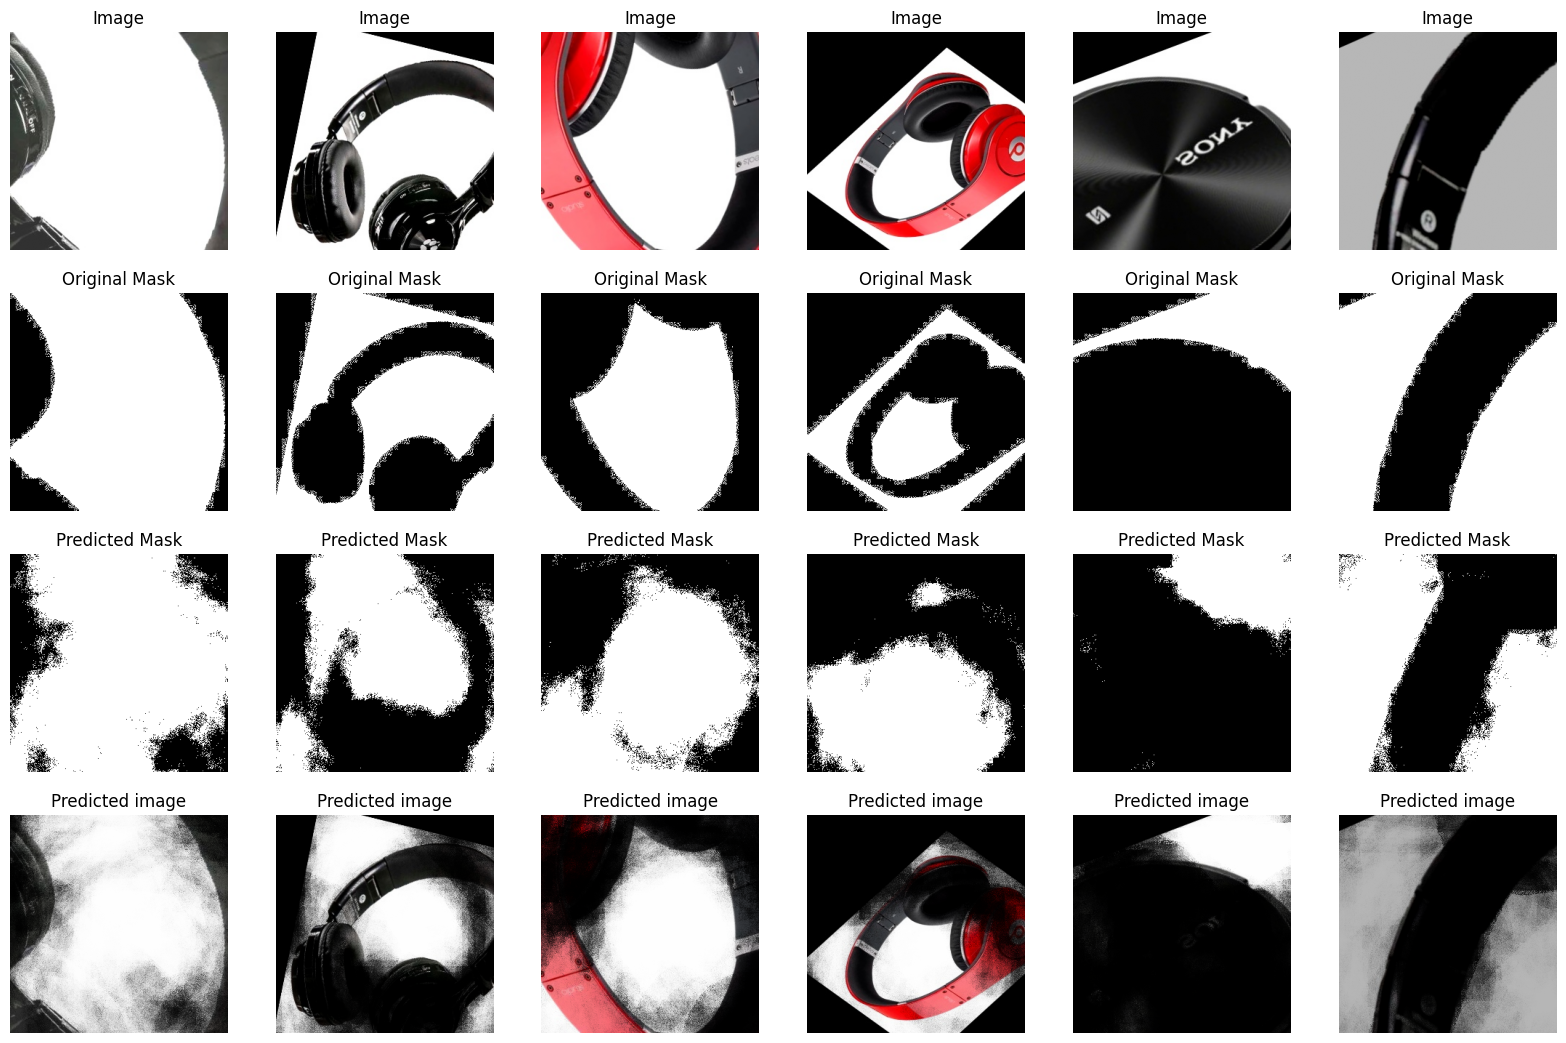

In [19]:
plot_results(x_v, y_v, model.predict(x_v), 2 * 3)

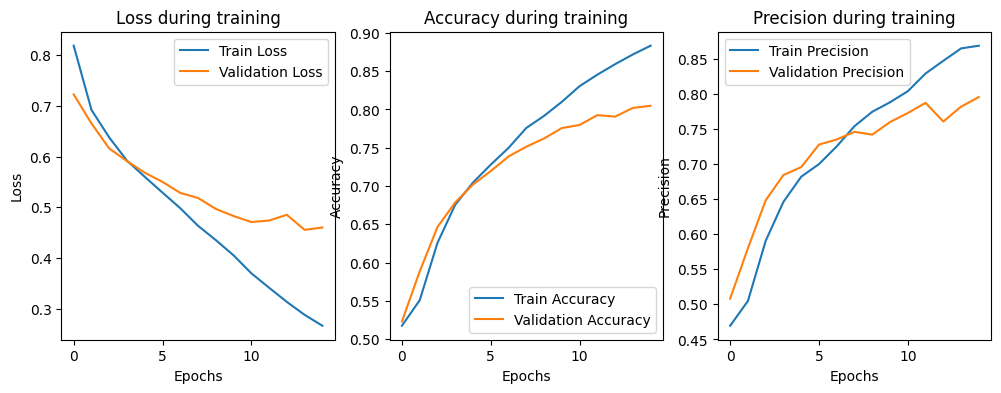

In [21]:
plot_hist(hst)

## U-net

2. **U-net** - Архитектура нейросети, созданная для сегментации изображений
Состоит из кодировщика и декодировщика
    1. *Кодировщик* - Состоит из свёрточных слоёв, позволяющих искать нужные признаки.
    2. *Декодировщик* - Состоит из транспонированных свёрточных слоёв, разворачивающих изображение и уменьшающих кол-во фильтров.

In [22]:
from tensorflow.keras.layers import *

In [23]:
def unet_model(input_shape):
    inputs = Input(shape=input_shape)

    # Энергия спуска
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Декодирование
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)  # Используйте softmax, если у вас больше классов
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

    return model

In [24]:
inputs = Input(shape=(mass_img[0].shape))
# Кодировщик
c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
p1 = MaxPooling2D((2, 2))(c1)
# Декодировщик
u2 = UpSampling2D((2, 2))(p1)
u2 = Concatenate()([u2, c1])
c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
# Выходной слой
outputs = Conv2D(1, (1, 1), activation='sigmoid')(c2)

# Создаем модель
model_u = tf.keras.Model(inputs=[inputs], outputs=[outputs])

In [25]:
# model_u1 = unet_model((size_img[:], 3))

In [26]:
# Компилируем модель
model_u.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'precision'])
# model_u1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'precision'])

In [27]:
type(y_t)

numpy.ndarray

In [28]:
# hst_u1 = model_u1.fit(x_t, y_t, validation_data=(x_v, y_v), epochs=10, batch_size=32)

In [29]:
# Обучаем модель
hst_u = model_u.fit(x_t, y_t, validation_data=(x_v, y_v), epochs=20, batch_size=20)  # При batch_size=32 модель тренируется слишком долго

Epoch 1/20


d:\PyInterpreters\Big_data\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_6']
Received: inputs=Tensor(shape=(None, 300, 300, 3))
  warnings.warn(msg)


10/10 ━━━━━━━━━━━━━━━━━━━━ 121s 12s/step - accuracy: 0.6481 - loss: 0.5740 - precision: 0.5428 - val_accuracy: 0.9328 - val_loss: 0.4567 - val_precision: 0.9952
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 116s 12s/step - accuracy: 0.8934 - loss: 0.3414 - precision: 0.8638 - val_accuracy: 0.8735 - val_loss: 0.2710 - val_precision: 0.8055
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 124s 12s/step - accuracy: 0.9106 - loss: 0.2370 - precision: 0.8621 - val_accuracy: 0.9476 - val_loss: 0.1467 - val_precision: 0.9293
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 117s 12s/step - accuracy: 0.9409 - loss: 0.1610 - precision: 0.9147 - val_accuracy: 0.9664 - val_loss: 0.1269 - val_precision: 0.9797
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 131s 13s/step - accuracy: 0.9578 - loss: 0.1330 - precision: 0.9531 - val_accuracy: 0.9677 - val_loss: 0.1255 - val_precision: 0.9868
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 124s 12s/step - accuracy: 0.9614 - loss: 0.1285 - precision: 0.9624 - val_accuracy: 0.9664 - val_loss: 0.1309 - v

In [30]:
# plot_results(x_v, y_v, model_u1.predict(x_v), 2 * 3)

d:\PyInterpreters\Big_data\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_6']
Received: inputs=Tensor(shape=(32, 300, 300, 3))
  warnings.warn(msg)


2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step


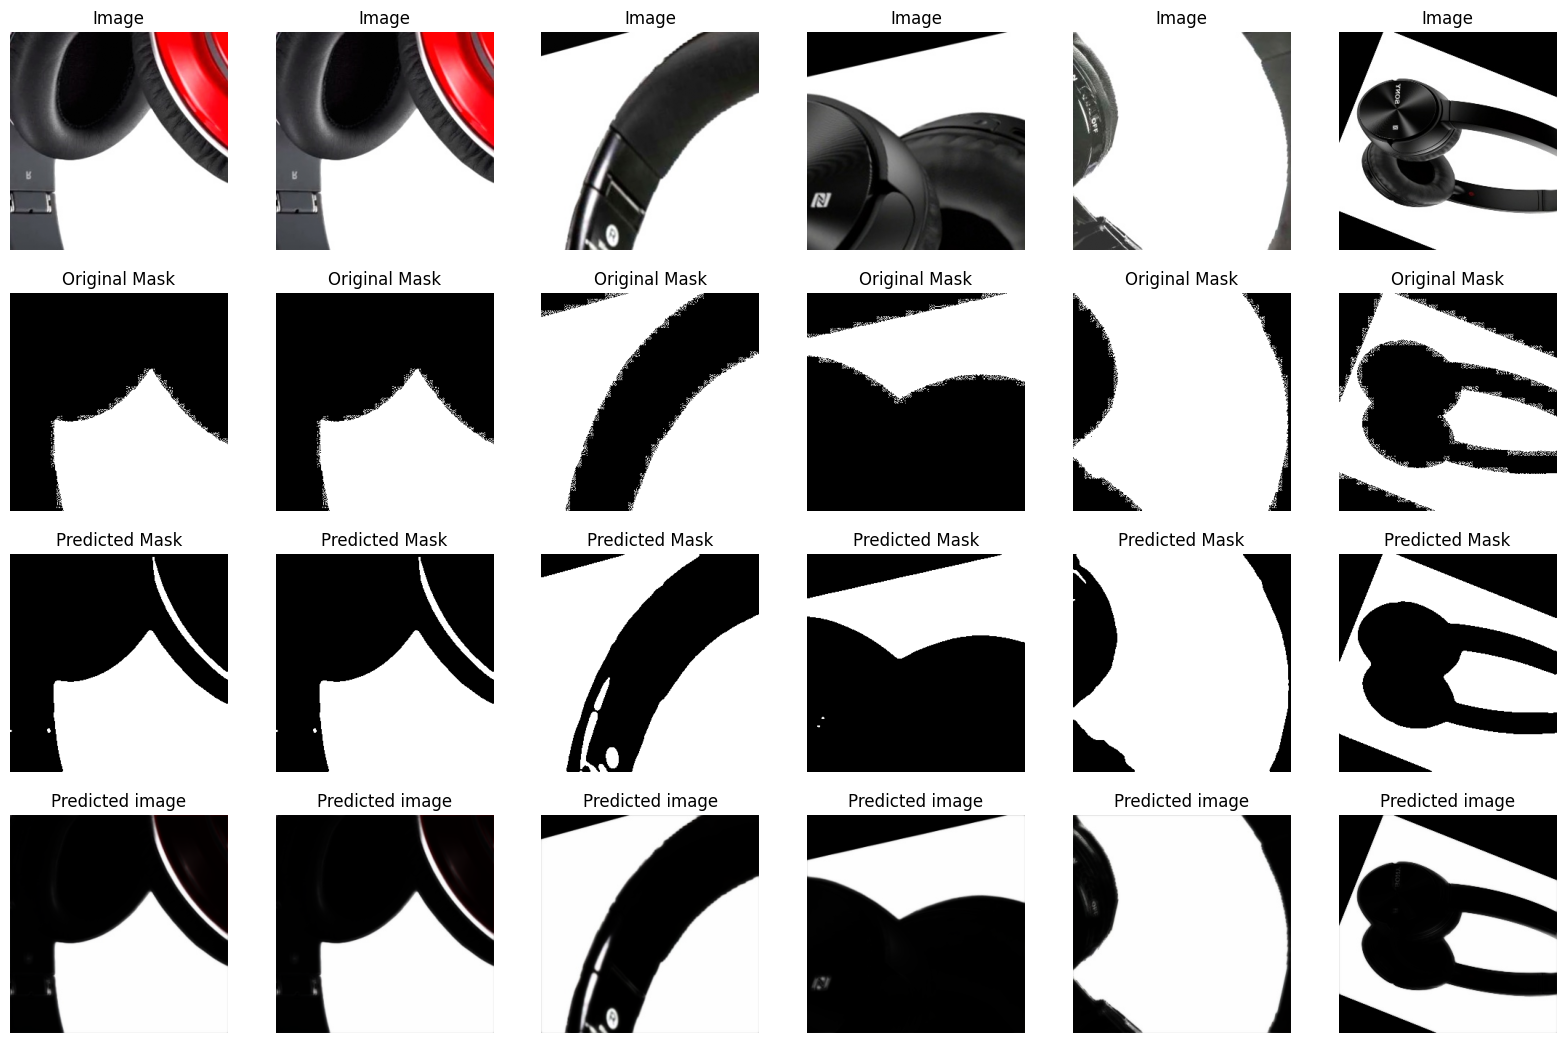

In [31]:
plot_results(x_v, y_v, model_u.predict(x_v), 2 * 3)

In [32]:
# plot_hist(hst_u1)

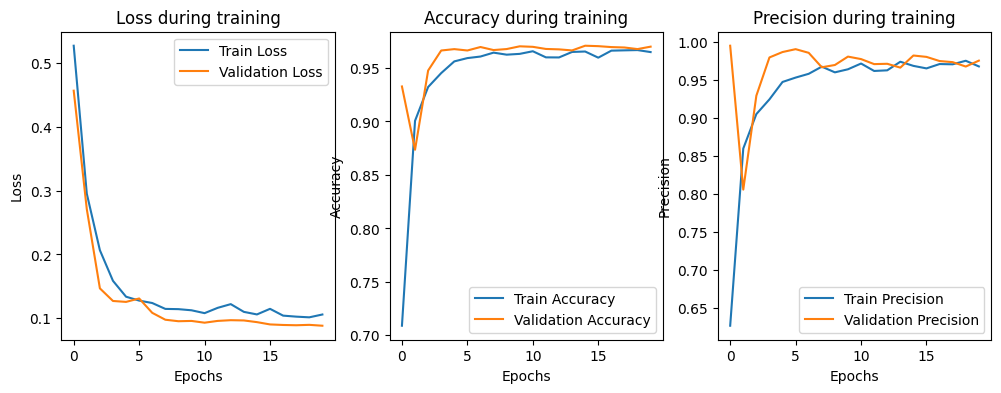

In [33]:
plot_hist(hst_u)